# BASELINE NEURAL NETWORK

In [1]:
import scipy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2

from torchvision import datasets
from torch.utils.data import TensorDataset, Subset, ConcatDataset

import torch.nn as nn
import torch.nn.functional as F

import time
import os
import pickle
from collections import Counter

### Reproducibility

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### Set the device

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


## Load and preprocess the data MNIST

### Data overview

In [5]:
# Download training data
train_data = datasets.MNIST(root="data", train=True, download=True)
print('Train data: ', len(train_data))
# Download test data
test_data = datasets.MNIST(root="data", train=False, download=True)
print('Test data: ', len(test_data))
print(train_data[1][0])

Train data:  60000
Test data:  10000
<PIL.Image.Image image mode=L size=28x28 at 0x7FB96D26A260>


There are 60000 28x28 grayscale images in the train dataset and 10000 28x28 grayscale images in the test dataset.

In [6]:
label_data = [train_data[i][1] for i in range(len(train_data))]
print(Counter(label_data))

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


We have 10 labels (10 classes) 0-9 for ten digits 0-9.

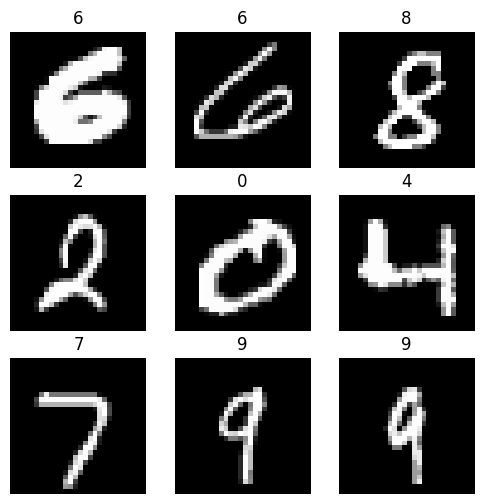

In [ ]:
# Visualize some datapoints
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
for i in range(1, cols * rows + 1):
    plt.axis("off")
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
# Stick all the images together
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255

mean=mean.tolist()
std=std.tolist()

transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
#transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transformer) # Train set
test_data = datasets.MNIST(root = './data', train = False, download = True, transform = transformer) # Test set

Since we only take 100 images from the train dataset to train and we have 10 classes (10 digits), then we could take it randomly or random 10 images from each class (each digit)

In [8]:
def sample_100(data, random_bool = True):
  if random_bool:
    torch.manual_seed(42)
    subset_indices = torch.randperm(len(data))[:100]
    subset_data = torch.utils.data.Subset(data, subset_indices)
  else:
    subset_data = []
    for i in range(10):
      label_indices = torch.where(data.targets == i)[0]
      random.seed(42)
      subset_indices = random.sample(label_indices.tolist(), 10)
      subset_data.append(Subset(data, subset_indices))
    subset_data = ConcatDataset(subset_data)
  return subset_data

train_100 = sample_100(train_data) # data with only 100 images take randomly
len(train_100)

100

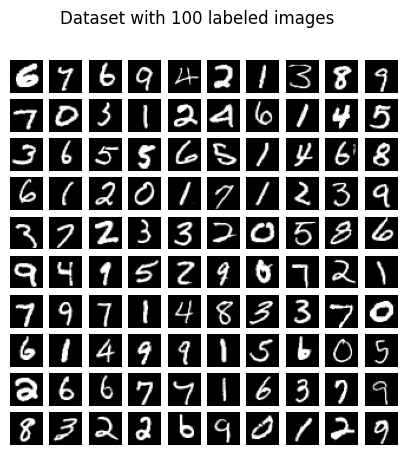

In [9]:
def visualize_images(data, title='', rows = 10, cols =10 , fig_size = (5,5)):
  # function to visualize images

  plt.figure(figsize=fig_size)  # Set the figure size to 5x5
  for idx, img in enumerate(data):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.axis('off')
  plt.suptitle(title)
  plt.show()

visualize_images(train_100, title='Dataset with 100 labeled images' , rows = 10 , cols = 10 , fig_size = (5,5))

We use 100 labeled images in **train_100** to train the baseline model. We splited this data into train set and validation set (25%) with stratifying the proportions of classes

In [10]:
from sklearn.model_selection import train_test_split
random_state = 42 # for reproductible results
# Get labels to stratify the split
labels = []
for i in range(len(train_100)) :
  _, label = train_100[i]
  labels.append(label)

# Split indices if the dataset is composed of images
train_indices, val_indices = train_test_split(list(range(len(labels))),
                                              test_size = 0.25,
                                              stratify = labels,
                                              random_state = random_state,
                                              shuffle=True)

trainset = torch.utils.data.Subset(train_100, train_indices)
valset = torch.utils.data.Subset(train_100, val_indices)

In [11]:
label_data = [trainset[i][1] for i in range(len(trainset))]
print(Counter(label_data))

Counter({6: 11, 1: 10, 2: 9, 9: 9, 7: 8, 3: 8, 5: 6, 0: 5, 4: 5, 8: 4})


### Model Architecture

In [12]:
def get_memory_params_model(model):
  # Model architecture
  print(model)
  print("Model memory allocation : {:.2e}".format(torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)))

  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  print("{} total parameters.".format(total_params))
  total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("{} training parameters.".format(total_trainable_params))

### Simple Neural Network Architecture

In [ ]:
class Net1(nn.Module):
  def __init__(self):
    super().__init__()

    self.lin1 = nn.Linear(in_features = 784, out_features = 512)
    #self.dp1 = nn.Dropout(p = 0.2)
    self.batchnorm1 = nn.BatchNorm1d(512)
    self.lin2 = nn.Linear(in_features = 512, out_features = 128)
    #self.dp2 = nn.Dropout(p = 0.3)
    self.batchnorm2 = nn.BatchNorm1d(128)
    self.lin3 = nn.Linear(in_features = 128, out_features = 64)
    #self.dp3 = nn.Dropout(p = 0.2)
    self.batchnorm3 = nn.BatchNorm1d(64)
    self.lin4 = nn.Linear(in_features = 64, out_features = 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.lin1(x))
    x = self.batchnorm1(x)
    #x = self.dp1(x)
    x = F.relu(self.lin2(x))
    x = self.batchnorm2(x)
    #x = self.dp2(x)
    x = F.relu(self.lin3(x))
    x = self.batchnorm3(x)
    #x = self.dp3(x)
    x = self.lin4(x)
    return x

net1 = Net1().to(device)
get_memory_params_model(net1)

Net1(
  (lin1): Linear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=64, out_features=10, bias=True)
)
Model memory allocation : 2.11e+07
477898 total parameters.
477898 training parameters.


In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super().__init__()

    self.lin1 = nn.Linear(in_features = 784, out_features = 128)
    self.batchnorm1 = nn.BatchNorm1d(128)
    self.lin2 = nn.Linear(in_features = 128, out_features = 64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    #self.dp = nn.Dropout(p = 0.2)
    self.lin3 = nn.Linear(in_features = 64, out_features = 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.lin1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.lin2(x))
    x = self.batchnorm2(x)
    #x = self.dp(x)
    x = self.lin3(x)
    return x

net2 = Net2().to(device)
get_memory_params_model(net2)

Net2(
  (lin1): Linear(in_features=784, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=64, out_features=10, bias=True)
)
Model memory allocation : 2.07e+07
109770 total parameters.
109770 training parameters.


### CNN Architecture

In [18]:
class CNN1_norm(nn.Module):
  def __init__(self):
    super().__init__() # always subclass
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding = "same") # conv layer 28x28x32
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2) # maxpooling 14x14x32
    #self.dp1 = nn.Dropout(p = 0.2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # first conv layer 12x12x64
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2) # maxpooling 6x6x64
    #self.dp2 = nn.Dropout(p = 0.3)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # conv layer 4x4x128
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2) # maxpooling 2x2x128
    #self.dp3 = nn.Dropout(p = 0.2)

    self.fc1 = nn.Linear(128*2*2, 128) # we have 10 probability classes to predict so 10 output features
    self.batchnorm4 = nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(128, 64)
    self.batchnorm5 = nn.BatchNorm1d(64)
    #self.dp4 = nn.Dropout(p = 0.3)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = self.pool1(x)
    #x = self.dp1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = self.pool2(x)
    #x = self.dp2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = self.pool3(x)
    #x = self.dp3(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    #x = self.dp4(x)
    x = self.fc3(x)

    return x

### Train

In [13]:
def load_data(train, val, test, train_batch, val_batch, test_batch):
  torch.manual_seed(42)
  trainloader = torch.utils.data.DataLoader(train, batch_size=train_batch,
                                          shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(val, batch_size=val_batch,
                                         shuffle=False, num_workers=2)
  testloader = torch.utils.data.DataLoader(test, batch_size=test_batch,
                                         shuffle=False, num_workers=2)
  return trainloader,valloader,testloader

trainloader,valloader,testloader = load_data(trainset, valset, test_data, 20, 20, 20)

In [14]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

### Early stopping

In [15]:
# class to implement Early Stopping
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float('inf')

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        return True
    return False

In [16]:
# Train function
def train_model(model, epochs, train_loader, val_loader, optimizer_name = 'Adam', patience = 1, early_stopping = True, learning_rate = 0.001, device=None):
  torch.manual_seed(42)
  # Init
  output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
  criterion = nn.CrossEntropyLoss() # we instantiate the loss function
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate) # we instantiate Adam optimizer that takes as inputs the model parameters and learning rate

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  # initialize the early_stopping object
  if early_stopping:
    early_stopper = EarlyStopping(patience=patience)

  for epoch in tqdm(range(epochs)):
    torch.manual_seed(42)
    # Training loop
    model.train() # always specify that the model is in training mode
    running_loss = 0.0 # init loss
    running_acc = 0.

    # Loop over batches returned by the data loader
    for idx, batch in enumerate(train_loader):

      # get the inputs; batch is a tuple of (inputs, labels)
      inputs, labels = batch
      inputs = inputs.to(device) # put the data on the same device as the model
      labels = labels.to(device)

      # put to zero the parameters gradients at each iteration to avoid accumulations
      optimizer.zero_grad()

      # forward pass + backward pass + update the model parameters
      out = model(x=inputs) # get predictions
      loss = criterion(out, labels) # compute loss
      loss.backward() # compute gradients
      optimizer.step() # update model parameters according to these gradients and our optimizer strategy

      # Iteration train metrics
      running_loss += loss.view(1).item()
      t_out = output_fn(out.detach()).cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
      t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
      ground_truth = labels.cpu().numpy() # detach the labels from GPU device
      running_acc += get_accuracy(ground_truth, t_out)

    ### Epochs train metrics ###
    acc_train.append(running_acc/len(train_loader))
    loss_train.append(running_loss/len(train_loader))

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval() # put the model in evaluation mode (this prevents the use of dropout layers for instance)

    ### VALIDATION DATA ###
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
          ground_truth = labels.cpu().numpy() # detach the labels from GPU device
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
        '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))

    # early_stopping check if the validation loss has decresed, if yes, it will make a checkpoint of the current model
    if early_stopping:
      stop_bool = early_stopper.early_stop(loss_valid[epoch])
      if stop_bool:
        print("Early stopping")
        break

  # load the last checkpoint with the best model
  #if early_stopping:
    #model.load_state_dict(torch.load('checkpoint.pt'))

  return model, loss_train, acc_train, loss_valid, acc_valid

In [17]:
def plot_accuracy_loss(model_name, loss_train, loss_valid, acc_train, acc_valid) :
  """plot the accuracy and loss functions (for each epoch)
    early_stop_point = True: visualize the early stopping
  """

  fig = plt.figure(figsize = (16, 8))

  # --- Metrics plot
  def plot_metric(model_name, metric_train, metric_valid, metric_name) :
    """plot metrics of both datasets"""
    plt.plot(range(1, len(metric_train) + 1), metric_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    plt.plot(range(1, len(metric_valid) + 1), metric_valid, label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    # find position of lowest validation loss
    plt.title(f"{model_name}-model {metric_name}")
    plt.xlabel('#Epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend(bbox_to_anchor=( 1., 1.))

  # Plot loss functions
  ax = fig.add_subplot(121)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, loss_train, loss_valid, "Loss")

  # Plot accuracy function
  ax = fig.add_subplot(122)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, acc_train, acc_valid, "Accuracy")

##Evaluation on Test set

In [ ]:
def test_model(model, test_loader):
  output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
  model.eval()
  torch.manual_seed(42)
  with torch.no_grad():
    idx = 0
    for batch in test_loader:
      inputs,labels=batch
      inputs=inputs.to(device)
      labels=labels.to(device)
      if idx==0:
        t_out = model(x=inputs)
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out=t_out.argmax(axis=1)
        ground_truth = labels.detach().cpu().numpy()
      else:
        out = model(x=inputs)
        t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
      idx+=1

  print("Test accuracy {}".format(get_accuracy(ground_truth,t_out)))
  return t_out, ground_truth

## Data augmentation

The train set has only 80 images, it is a small data set for training, so we use data augmentation thanks to image rotations, scale, crop, translation, etc. We try different data augmentation by transforming images, then train with model cnn1

In [20]:
def data_transform(data, transformer_list = [], num_per_img = 10):
  """
  data augmentation applying each transforms for each original image,
  num_per_img is the number of images augmented from each original image for each transform
  """

  torch.manual_seed(42)
  augmented_data = []
  augmented_labels = []
  for i in range(len(data)):
    # Data augmentation
    img, label = data[i]
    augmented_data.append(img)
    augmented_labels.append(label)
    for t in transformer_list:

      # Generate new images from the original image
      for _ in range(num_per_img) :
        random.seed(42)
        new_img = t(img)
        augmented_data.append(new_img)

      # Update new labels
      augmented_labels.extend([label] * (num_per_img))

  augmented_data = torch.stack(augmented_data) # Concatenate a sequence of tensors
  augmented_labels = torch.tensor(augmented_labels)

  return TensorDataset(augmented_data, augmented_labels)

In [21]:
random.seed(seed)

rotation15 = transforms.Compose([transforms.RandomRotation(15),
                                 transforms.Normalize(mean, std)])

rotation30 = transforms.Compose([transforms.RandomRotation(30),
                                 transforms.Normalize(mean, std)])

rotation45 = transforms.Compose([transforms.RandomRotation(45),
                                 transforms.Normalize(mean, std)])

rotation60 = transforms.Compose([transforms.RandomRotation(60),
                                 transforms.Normalize(mean, std)])

rotation75 = transforms.Compose([transforms.RandomRotation(75),
                                 transforms.Normalize(mean, std)])

crop_resize = transforms.Compose([transforms.RandomResizedCrop(28, scale=(0.8, 1), ratio = (1,1)),
                                  transforms.Normalize(mean, std)])

translation = transforms.Compose([transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
                                  transforms.Normalize(mean, std)])

shear15 = transforms.Compose([transforms.RandomAffine(0,shear=15),
                            transforms.Normalize(mean, std)])

shear30 = transforms.Compose([transforms.RandomAffine(0,shear=30),
                            transforms.Normalize(mean, std)])

shear45 = transforms.Compose([transforms.RandomAffine(0,shear=45),
                            transforms.Normalize(mean, std)])

transform_pipeline1 = transforms.Compose([transforms.RandomRotation(45),
                                          transforms.RandomResizedCrop(28, scale=(0.8, 1), ratio = (1,1)),
                                          transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
                                          transforms.RandomAffine(degrees = 0, shear = 30),
                                          transforms.Normalize(mean, std)])

In [22]:
transformer_list1 = [rotation45, crop_resize, translation, shear30, transform_pipeline1]
#transformer_list2 = [rotation15, rotation30, rotation60, rotation75, crop_resize, translation, shear15, shear45, transform_pipeline1]
#transformer_list3 = [rotation60, crop_resize, translation, shear45, transform_pipeline1]
#transformer_list4 = [rotation15, crop_resize, translation, shear15, transform_pipeline1]

data_aug = data_transform(trainset, transformer_list1, num_per_img = 10)
len(data_aug)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


3825

In [ ]:
# Visualize the data augmentation
targets_aug = []
for img in data_aug:
  targets_aug.append(img[1])

indices_label = [i for i in range(len(targets_aug)) if targets_aug[i] == 5]
aug_5 = Subset(data_aug, indices_label[:50])
#ConcatDataset(aug_5)
#aug_5[0]
visualize_images(aug_5, title='Augmented images of digit 5' , rows = 5 , cols = 10 , fig_size = (12,12))

In [23]:
trainloader, valloader, testloader = load_data(data_aug, valset, test_data, 20, 20, 20)

### MLP 1

In [ ]:
net1_trained, loss_train, acc_train, loss_valid, acc_valid = train_model(net1, 20, trainloader, valloader, early_stopping = False, learning_rate = 0.001, device=device)

  5%|▌         | 1/20 [00:01<00:23,  1.26s/it]

| Epoch: 1/20 | Train: Loss 0.8772 Accuracy : 0.7448 | Val: Loss 1.2790 Accuracy : 0.7200



 10%|█         | 2/20 [00:02<00:20,  1.16s/it]

| Epoch: 2/20 | Train: Loss 0.3549 Accuracy : 0.9021 | Val: Loss 1.0942 Accuracy : 0.6400



 15%|█▌        | 3/20 [00:03<00:18,  1.06s/it]

| Epoch: 3/20 | Train: Loss 0.1679 Accuracy : 0.9576 | Val: Loss 1.0891 Accuracy : 0.6800



 20%|██        | 4/20 [00:04<00:16,  1.01s/it]

| Epoch: 4/20 | Train: Loss 0.1200 Accuracy : 0.9651 | Val: Loss 1.0148 Accuracy : 0.6400



 25%|██▌       | 5/20 [00:05<00:14,  1.02it/s]

| Epoch: 5/20 | Train: Loss 0.0743 Accuracy : 0.9802 | Val: Loss 1.4316 Accuracy : 0.5200



 30%|███       | 6/20 [00:06<00:13,  1.03it/s]

| Epoch: 6/20 | Train: Loss 0.0633 Accuracy : 0.9826 | Val: Loss 0.8908 Accuracy : 0.6800



 35%|███▌      | 7/20 [00:07<00:12,  1.04it/s]

| Epoch: 7/20 | Train: Loss 0.0430 Accuracy : 0.9901 | Val: Loss 0.8685 Accuracy : 0.6800



 40%|████      | 8/20 [00:08<00:11,  1.04it/s]

| Epoch: 8/20 | Train: Loss 0.0164 Accuracy : 0.9974 | Val: Loss 0.6350 Accuracy : 0.7200



 45%|████▌     | 9/20 [00:08<00:10,  1.05it/s]

| Epoch: 9/20 | Train: Loss 0.0056 Accuracy : 0.9992 | Val: Loss 0.5021 Accuracy : 0.8400



 50%|█████     | 10/20 [00:09<00:09,  1.05it/s]

| Epoch: 10/20 | Train: Loss 0.0024 Accuracy : 1.0000 | Val: Loss 0.6477 Accuracy : 0.7600



 55%|█████▌    | 11/20 [00:10<00:08,  1.05it/s]

| Epoch: 11/20 | Train: Loss 0.0013 Accuracy : 1.0000 | Val: Loss 0.5472 Accuracy : 0.8000



 60%|██████    | 12/20 [00:11<00:07,  1.06it/s]

| Epoch: 12/20 | Train: Loss 0.0009 Accuracy : 1.0000 | Val: Loss 0.5199 Accuracy : 0.8000



 65%|██████▌   | 13/20 [00:13<00:07,  1.04s/it]

| Epoch: 13/20 | Train: Loss 0.0008 Accuracy : 1.0000 | Val: Loss 0.5092 Accuracy : 0.8000



 70%|███████   | 14/20 [00:14<00:06,  1.11s/it]

| Epoch: 14/20 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.5004 Accuracy : 0.8000



 75%|███████▌  | 15/20 [00:15<00:05,  1.08s/it]

| Epoch: 15/20 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 0.4918 Accuracy : 0.8000



 80%|████████  | 16/20 [00:16<00:04,  1.04s/it]

| Epoch: 16/20 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 0.4758 Accuracy : 0.8000



 85%|████████▌ | 17/20 [00:17<00:03,  1.01s/it]

| Epoch: 17/20 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.4779 Accuracy : 0.8000



 90%|█████████ | 18/20 [00:18<00:02,  1.00s/it]

| Epoch: 18/20 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.4759 Accuracy : 0.8000



 95%|█████████▌| 19/20 [00:19<00:00,  1.02it/s]

| Epoch: 19/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.4780 Accuracy : 0.8000



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

| Epoch: 20/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.4826 Accuracy : 0.8000



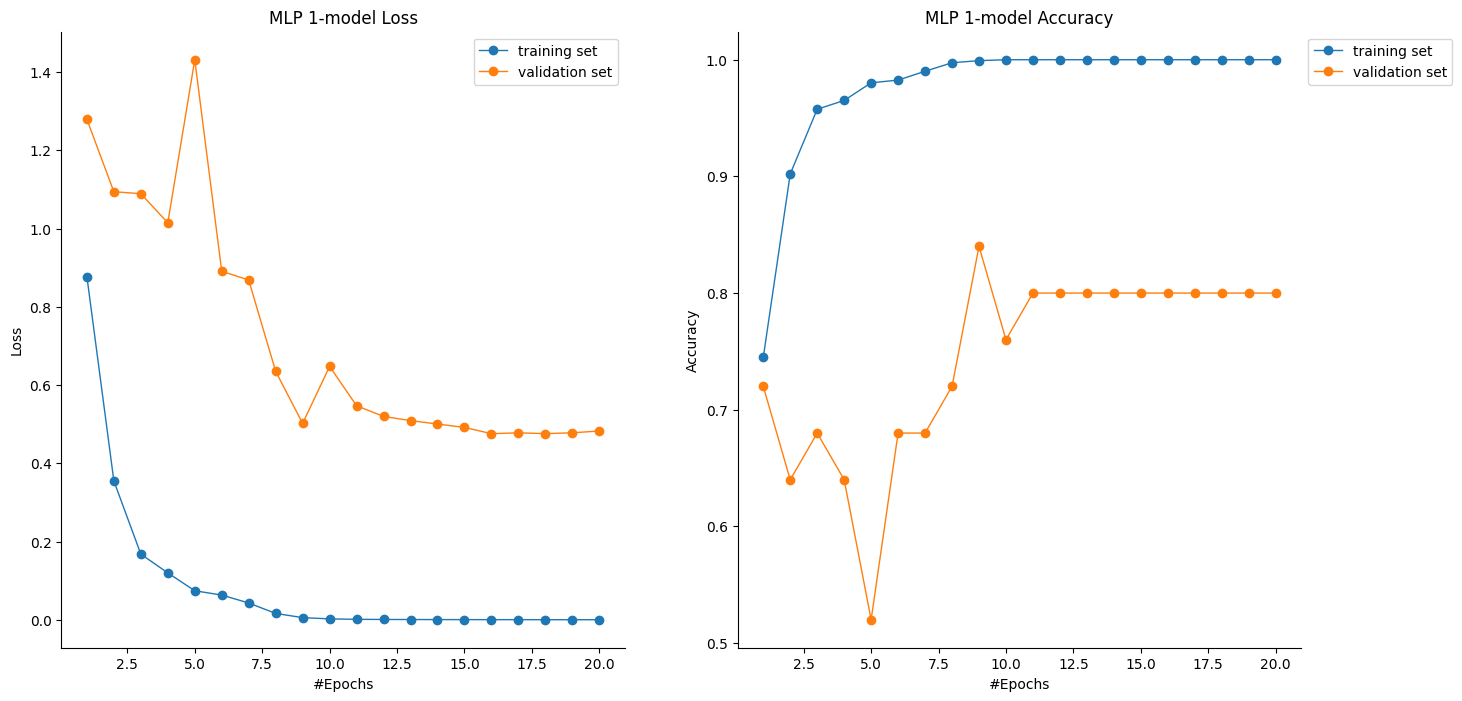

In [ ]:
plot_accuracy_loss('MLP 1', loss_train, loss_valid, acc_train, acc_valid)

Regarding the learning curves of the MLP 1, we could see that the validation loss is unstable and shows signs of diverging after epoch 18. The best validation loss achieved is
about 0.5. The validation accuracy does not seem to have increased after epoch 11. The best validation accuracy is 0.85. Therefore, the MLP 1 is not robust.

### MLP 2

In [ ]:
net2_trained, loss_train, acc_train, loss_valid, acc_valid = train_model(net2, 20, trainloader, valloader, early_stopping = False, learning_rate = 0.001, device=device)

  5%|▌         | 1/20 [00:00<00:16,  1.15it/s]

| Epoch: 1/20 | Train: Loss 0.9563 Accuracy : 0.7273 | Val: Loss 1.3970 Accuracy : 0.6000



 10%|█         | 2/20 [00:01<00:15,  1.15it/s]

| Epoch: 2/20 | Train: Loss 0.4457 Accuracy : 0.8781 | Val: Loss 1.1578 Accuracy : 0.6400



 15%|█▌        | 3/20 [00:02<00:14,  1.16it/s]

| Epoch: 3/20 | Train: Loss 0.2424 Accuracy : 0.9383 | Val: Loss 0.9577 Accuracy : 0.6400



 20%|██        | 4/20 [00:03<00:13,  1.16it/s]

| Epoch: 4/20 | Train: Loss 0.1392 Accuracy : 0.9680 | Val: Loss 0.9167 Accuracy : 0.6400



 25%|██▌       | 5/20 [00:04<00:13,  1.09it/s]

| Epoch: 5/20 | Train: Loss 0.0723 Accuracy : 0.9865 | Val: Loss 0.8581 Accuracy : 0.6800



 30%|███       | 6/20 [00:05<00:13,  1.00it/s]

| Epoch: 6/20 | Train: Loss 0.0476 Accuracy : 0.9919 | Val: Loss 0.7087 Accuracy : 0.7600



 35%|███▌      | 7/20 [00:06<00:13,  1.02s/it]

| Epoch: 7/20 | Train: Loss 0.0220 Accuracy : 0.9990 | Val: Loss 0.7027 Accuracy : 0.7200



 40%|████      | 8/20 [00:07<00:11,  1.03it/s]

| Epoch: 8/20 | Train: Loss 0.0079 Accuracy : 1.0000 | Val: Loss 0.6643 Accuracy : 0.6400



 45%|████▌     | 9/20 [00:08<00:10,  1.07it/s]

| Epoch: 9/20 | Train: Loss 0.0049 Accuracy : 1.0000 | Val: Loss 0.5690 Accuracy : 0.8000



 50%|█████     | 10/20 [00:09<00:09,  1.10it/s]

| Epoch: 10/20 | Train: Loss 0.0030 Accuracy : 1.0000 | Val: Loss 0.5587 Accuracy : 0.8000



 55%|█████▌    | 11/20 [00:10<00:08,  1.12it/s]

| Epoch: 11/20 | Train: Loss 0.0023 Accuracy : 1.0000 | Val: Loss 0.5489 Accuracy : 0.8000



 60%|██████    | 12/20 [00:10<00:07,  1.14it/s]

| Epoch: 12/20 | Train: Loss 0.0018 Accuracy : 1.0000 | Val: Loss 0.5584 Accuracy : 0.8000



 65%|██████▌   | 13/20 [00:11<00:06,  1.14it/s]

| Epoch: 13/20 | Train: Loss 0.0015 Accuracy : 1.0000 | Val: Loss 0.5565 Accuracy : 0.8000



 70%|███████   | 14/20 [00:12<00:05,  1.15it/s]

| Epoch: 14/20 | Train: Loss 0.0012 Accuracy : 1.0000 | Val: Loss 0.5533 Accuracy : 0.8000



 75%|███████▌  | 15/20 [00:13<00:04,  1.16it/s]

| Epoch: 15/20 | Train: Loss 0.0010 Accuracy : 1.0000 | Val: Loss 0.5561 Accuracy : 0.8000



 80%|████████  | 16/20 [00:14<00:03,  1.16it/s]

| Epoch: 16/20 | Train: Loss 0.0009 Accuracy : 1.0000 | Val: Loss 0.5496 Accuracy : 0.8000



 85%|████████▌ | 17/20 [00:15<00:02,  1.15it/s]

| Epoch: 17/20 | Train: Loss 0.0007 Accuracy : 1.0000 | Val: Loss 0.5512 Accuracy : 0.7600



 90%|█████████ | 18/20 [00:16<00:01,  1.17it/s]

| Epoch: 18/20 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.5517 Accuracy : 0.7600



 95%|█████████▌| 19/20 [00:17<00:00,  1.09it/s]

| Epoch: 19/20 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.5744 Accuracy : 0.8000



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]

| Epoch: 20/20 | Train: Loss 0.0007 Accuracy : 1.0000 | Val: Loss 0.6045 Accuracy : 0.8000



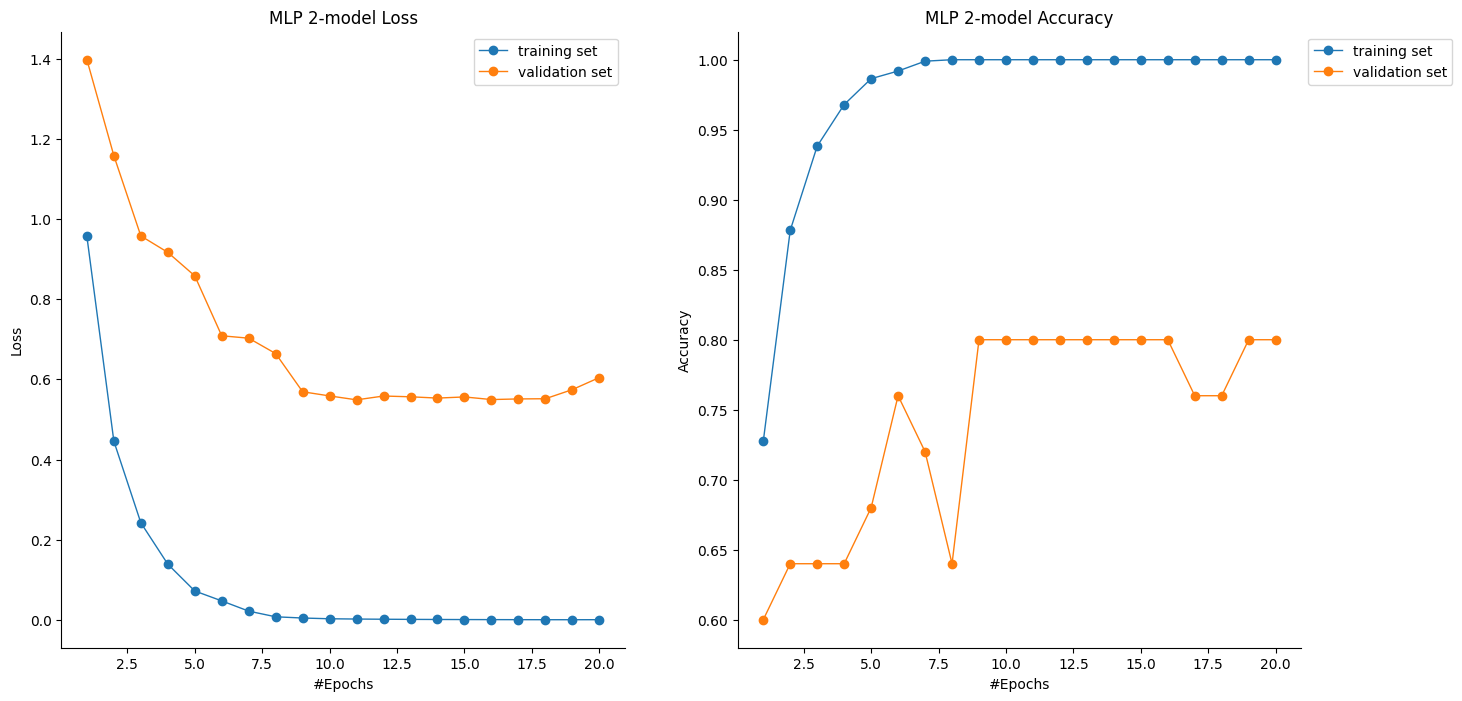

In [ ]:
plot_accuracy_loss('MLP 2', loss_train, loss_valid, acc_train, acc_valid)

Regarding the learning curves of the MLP 2, we can see that the validation loss gradually decreases throughout the training. However, it shows signs of diverging after epoch 18. The best validation loss achieved is above 0.5. The validation accuracy is unstable and does not improve after epoch 9. The best validation accuracy is about 0.8. Therefore, the MLP 2 is also not robust.

### CNN

In [25]:
# define cnn model
cnn1norm_aug = CNN1_norm().to(device)
get_memory_params_model(cnn1norm_aug)

CNN1_norm(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm5): BatchNorm

In [26]:
cnn1_norm_aug_trained, loss_train, acc_train, loss_valid, acc_valid = train_model(cnn1norm_aug, 20, trainloader, valloader, early_stopping = False, learning_rate = 0.001, device=device)

  5%|▌         | 1/20 [00:02<00:52,  2.74s/it]

| Epoch: 1/20 | Train: Loss 0.7246 Accuracy : 0.8414 | Val: Loss 1.2269 Accuracy : 0.5200



 10%|█         | 2/20 [00:03<00:32,  1.82s/it]

| Epoch: 2/20 | Train: Loss 0.1946 Accuracy : 0.9581 | Val: Loss 0.5013 Accuracy : 0.8800



 15%|█▌        | 3/20 [00:05<00:26,  1.53s/it]

| Epoch: 3/20 | Train: Loss 0.0838 Accuracy : 0.9865 | Val: Loss 0.3792 Accuracy : 0.9600



 20%|██        | 4/20 [00:06<00:22,  1.39s/it]

| Epoch: 4/20 | Train: Loss 0.0344 Accuracy : 0.9956 | Val: Loss 0.4221 Accuracy : 0.8800



 25%|██▌       | 5/20 [00:07<00:19,  1.32s/it]

| Epoch: 5/20 | Train: Loss 0.0145 Accuracy : 0.9984 | Val: Loss 0.2719 Accuracy : 0.9200



 30%|███       | 6/20 [00:08<00:18,  1.33s/it]

| Epoch: 6/20 | Train: Loss 0.0046 Accuracy : 1.0000 | Val: Loss 0.1905 Accuracy : 0.9600



 35%|███▌      | 7/20 [00:10<00:18,  1.44s/it]

| Epoch: 7/20 | Train: Loss 0.0028 Accuracy : 1.0000 | Val: Loss 0.1757 Accuracy : 0.9600



 40%|████      | 8/20 [00:11<00:16,  1.40s/it]

| Epoch: 8/20 | Train: Loss 0.0020 Accuracy : 1.0000 | Val: Loss 0.1694 Accuracy : 0.9600



 45%|████▌     | 9/20 [00:12<00:14,  1.33s/it]

| Epoch: 9/20 | Train: Loss 0.0016 Accuracy : 1.0000 | Val: Loss 0.1646 Accuracy : 0.9600



 50%|█████     | 10/20 [00:14<00:12,  1.29s/it]

| Epoch: 10/20 | Train: Loss 0.0013 Accuracy : 1.0000 | Val: Loss 0.1618 Accuracy : 0.9600



 55%|█████▌    | 11/20 [00:15<00:11,  1.25s/it]

| Epoch: 11/20 | Train: Loss 0.0010 Accuracy : 1.0000 | Val: Loss 0.1590 Accuracy : 0.9600



 60%|██████    | 12/20 [00:16<00:09,  1.23s/it]

| Epoch: 12/20 | Train: Loss 0.0009 Accuracy : 1.0000 | Val: Loss 0.1568 Accuracy : 0.9600



 65%|██████▌   | 13/20 [00:17<00:08,  1.21s/it]

| Epoch: 13/20 | Train: Loss 0.0007 Accuracy : 1.0000 | Val: Loss 0.1554 Accuracy : 0.9600



 70%|███████   | 14/20 [00:18<00:07,  1.20s/it]

| Epoch: 14/20 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.1542 Accuracy : 0.9600



 75%|███████▌  | 15/20 [00:20<00:06,  1.21s/it]

| Epoch: 15/20 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 0.1539 Accuracy : 0.9600



 80%|████████  | 16/20 [00:21<00:04,  1.23s/it]

| Epoch: 16/20 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 0.1537 Accuracy : 0.9600



 85%|████████▌ | 17/20 [00:22<00:04,  1.34s/it]

| Epoch: 17/20 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.1535 Accuracy : 0.9600



 90%|█████████ | 18/20 [00:24<00:02,  1.37s/it]

| Epoch: 18/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.1539 Accuracy : 0.9600



 95%|█████████▌| 19/20 [00:25<00:01,  1.33s/it]

| Epoch: 19/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.1537 Accuracy : 0.9600



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

| Epoch: 20/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.1552 Accuracy : 0.9600



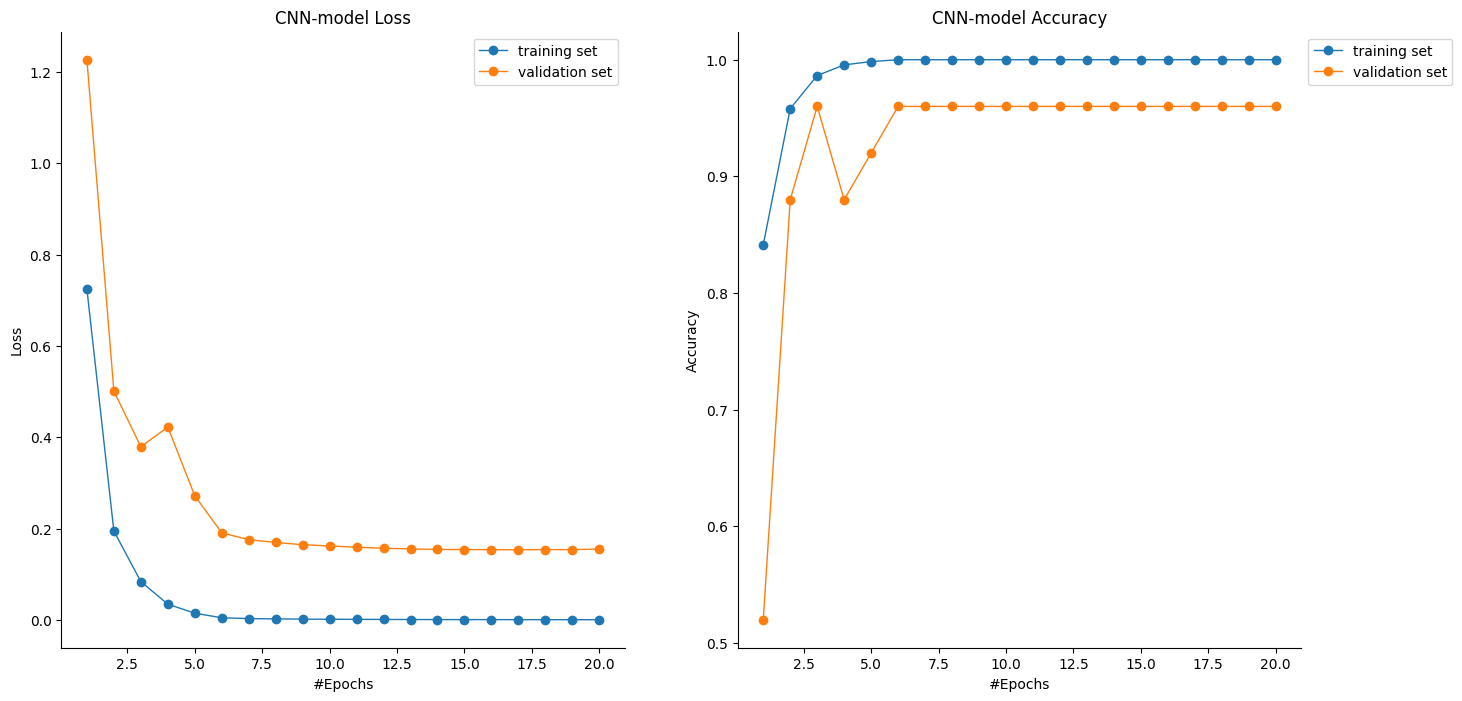

In [27]:
plot_accuracy_loss('CNN', loss_train, loss_valid, acc_train, acc_valid)

Regarding the learning curves of the CNN, we can see that the validation loss gradually decreases and shows signs of convergence during the training although the speed decreases
slowly after epoch 6. The best validation loss achieved is below 0.2. The validation accuracy increased rapidly and reached 0.96 in epoch 7. It did not decrease but did not
continue to improve in subsequent epochs. The best validation accuracy acheived is 0.96. Therefore, the CNN is far better than the 2 MLPs. It is the most robust model with the
lowest validation loss and highest validation accuracy

### Evaluation the CNN on test set

In [ ]:
# Evaluation on test set
cnn_out, ground_truth = test_model(cnn1_norm_aug_trained, testloader) # CNN1 with batch normoalization

Test accuracy 0.9127


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, size=15):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(size,size+2))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=18, family='serif')
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    #Set the font type and size of the colorbar
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("serif")

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontname='serif', size=14)
    plt.yticks(tick_marks, classes, fontname='serif', size=14)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 family='serif',
                 size=12)


    plt.ylabel('True label', size=18, fontname='serif')
    plt.xlabel('Predicted label', size=18, fontname='serif')
    plt.tight_layout()
    plt.show()

In [ ]:
cm_cnn = confusion_matrix(ground_truth, cnn_out) # confusion matrix

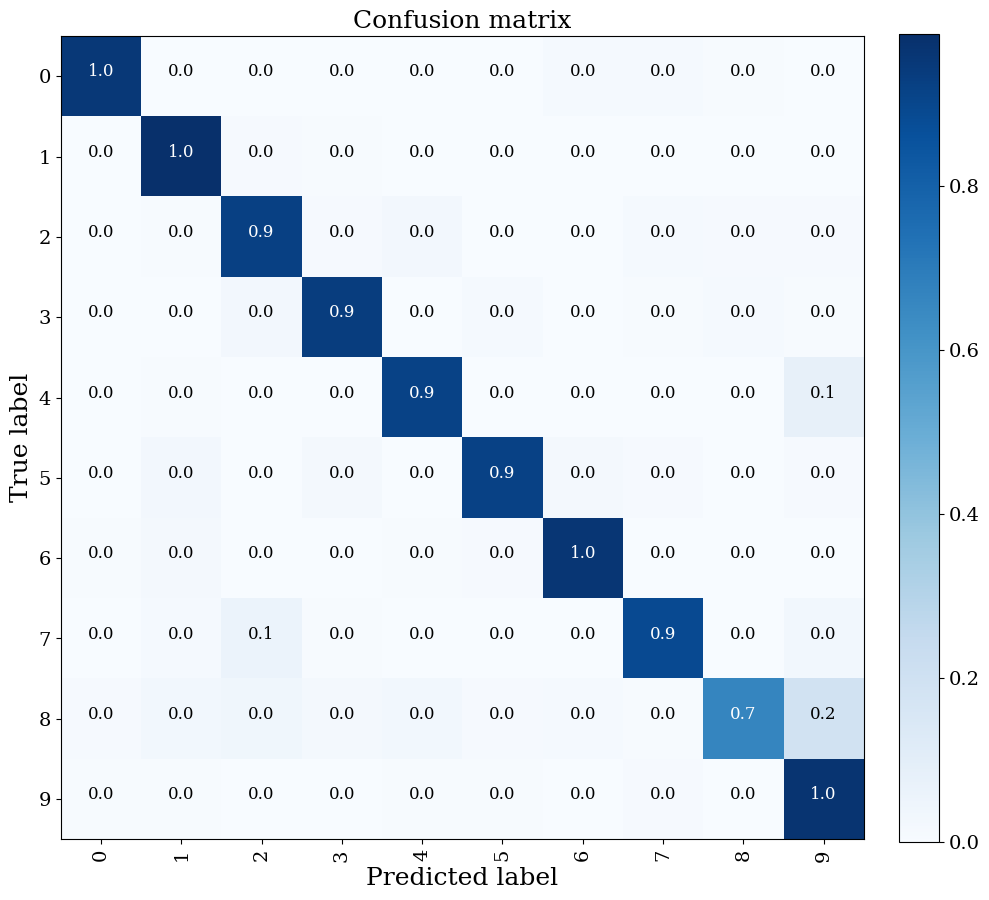

In [ ]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_confusion_matrix(cm_cnn, LABELS,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, size=10)

In [ ]:
LABELS_string = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(ground_truth, cnn_out, target_names=LABELS_string))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       980
           1       0.92      0.99      0.95      1135
           2       0.88      0.92      0.90      1032
           3       0.95      0.94      0.94      1010
           4       0.93      0.91      0.92       982
           5       0.96      0.92      0.94       892
           6       0.95      0.96      0.96       958
           7       0.93      0.89      0.91      1028
           8       0.96      0.66      0.78       974
           9       0.75      0.97      0.85      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



The confusion matrix is generally presented in the form of a table with the actual classes represented on the rows and the predicted classes represented on the columns. The diagonal elements of the table represent the rate of correct predictions for each class, while the non-diagonal elements represent the errors of classification. Therefore, we could see that the CNN model achieve very good performances for most digits except the digit 8, the model seems to sometimes misclassify images of the digit 8 as the digit 9. Moreover, images of the digit 7 are sometimes misclassified as the digit 2, and images of the digit 4 is sometimes misclassified as the digit 9. The evaluation of the CNN model on the test data is good according to the confusion matrix and the accuracy.

In [29]:
# save model

PATH2 = './cnn_final.pth'
torch.save(cnn1_norm_aug_trained.state_dict(), PATH2)

### Trying to optimizize the parameters of the CNN with Optuna

In [ ]:
!pip install optuna
import optuna
from optuna.trial import TrialState

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00


In [ ]:
class CNN1_norm_optuna(nn.Module):
  def __init__(self, trial):
    super().__init__() # always subclass
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding = "same") # conv layer 28x28x32
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2) # maxpooling 14x14x32
    #dropout_rate1 = trial.suggest_float("dropout_rate1", 0, 0.5,step=0.1)
    #self.dp1 = nn.Dropout(p = dropout_rate1)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # first conv layer 12x12x64
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2) # maxpooling 6x6x64
    #dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.5,step=0.1)
    #self.dp2 = nn.Dropout(p = dropout_rate2)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # conv layer 4x4x128
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2) # maxpooling 2x2x128
    #dropout_rate3 = trial.suggest_float("dropout_rate3", 0, 0.5,step=0.1)
    #self.dp3 = nn.Dropout(p = dropout_rate3)

    fc2_input_dim = trial.suggest_int("fc2_input_dim", 128, 256, 64)
    fc3_input_dim = trial.suggest_int("fc3_input_dim", 32, 128,32)

    self.fc1 = nn.Linear(128*2*2, fc2_input_dim) # we have 10 probability classes to predict so 10 output features
    self.batchnorm4 = nn.BatchNorm1d(fc2_input_dim)
    self.fc2 = nn.Linear(fc2_input_dim, fc3_input_dim)
    self.batchnorm5 = nn.BatchNorm1d(fc3_input_dim)
    #dropout_rate4 = trial.suggest_float("dropout_rate4", 0, 0.5,step=0.1)
    #self.dp4 = nn.Dropout(p = dropout_rate4)
    self.fc3 = nn.Linear(fc3_input_dim, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = self.pool1(x)
    #x = self.dp1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = self.pool2(x)
    #x = self.dp2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = self.pool3(x)
    #x = self.dp3(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    #x = self.dp4(x)
    x = self.fc3(x)

    return x

In [ ]:
epochs = 20
def objective(trial):
  # Generate the model.
  model = CNN1_norm_optuna(trial).to(device)

  # Generate the optimizers.

  # try RMSprop and SGD
  '''
  optimizer_name = trial.suggest_categorical("optimizer", ["RMSprop", "SGD"])
  momentum = trial.suggest_float("momentum", 0.0, 1.0)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr,momentum=momentum)
  '''
  #try Adam, AdaDelta adn Adagrad
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad"])
  lr = trial.suggest_categorical("lr", [1e-4, 1e-3, 1e-2, 1e-1])
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  batch_size=trial.suggest_int("batch_size", 10, 20, step=10)

  trainloader, valloader, testloader = load_data(data_aug, valset, test_data, batch_size, batch_size, batch_size)


  output_fn = torch.nn.Softmax(dim=1)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(epochs):

    # Training loop
    model.train() # always specify that the model is in training mode

    # Loop over batches returned by the data loader
    for idx, batch in enumerate(trainloader):

      # get the inputs; batch is a tuple of (inputs, labels)
      inputs, labels = batch
      inputs = inputs.to(device) # put the data on the same device as the model
      labels = labels.to(device)

      # put to zero the parameters gradients at each iteration to avoid accumulations
      optimizer.zero_grad()

      # forward pass + backward pass + update the model parameters
      out = model(inputs) # get predictions
      loss = criterion(out, labels) # compute loss
      loss.backward() # compute gradients
      optimizer.step() # update model parameters according to these gradients and our optimizer strategy

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval() # put the model in evaluation mode (this prevents the use of dropout layers for instance)

    ### VALIDATION DATA ###
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in valloader:
        inputs,labels=batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        if idx==0:
          t_out = model(inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
          ground_truth = labels.cpu().numpy() # detach the labels from GPU device
        else:
          out = model(inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

    accuracy = get_accuracy(ground_truth,t_out)
    trial.report(accuracy,epoch)
    # Handle pruning based on the intermediate value.
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-29 12:07:12,948] A new study created in memory with name: no-name-1a9f8cd5-c7b0-45b7-a556-61d4b5f6d549
<ipython-input-189-e57c686f5c21>:22: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  fc2_input_dim = trial.suggest_int("fc2_input_dim", 128, 256, 64)
<ipython-input-189-e57c686f5c21>:23: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  fc3_input_dim = trial.suggest_int("fc3_input_dim", 32, 128,32)
[I 2023-12-29 12:09:59,404] Trial 0 finished with value: 0.84 and parameters: {'fc2_input_dim': 192, 'fc3_input_dim': 64, 'optimizer': 'Adam', 'lr': 0.0001, 'batch_size': 10}. Best is trial 0 with value: 0.84.
[I 2023-12-29 12:12:51,084] Trial 1 finished with value: 0.44 and parameters: {'fc2_input_dim': 256, 'fc3_input_dim': 128, 'optimizer': 'Adadelta', 'lr': 0.001, 'batch_size': 10}. Best is trial 0 with value: 0.84.
[I 2023-12

Accuracy: 0.92
Best hyperparameters: {'fc2_input_dim': 192, 'fc3_input_dim': 64, 'optimizer': 'Adagrad', 'lr': 0.01, 'batch_size': 20}


### Train and evaluate the optimal CNN

In [ ]:
class CNN1_norm_optimal(nn.Module):
  def __init__(self):
    super().__init__() # always subclass
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding = "same") # conv layer 28x28x32
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2) # maxpooling 14x14x32

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # first conv layer 12x12x64
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2) # maxpooling 6x6x64

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # conv layer 4x4x128
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2) # maxpooling 2x2x128

    self.fc1 = nn.Linear(128*2*2, 192) # we have 10 probability classes to predict so 10 output features
    self.batchnorm4 = nn.BatchNorm1d(192)
    self.fc2 = nn.Linear(192, 64)
    self.batchnorm5 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = self.pool3(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = self.fc3(x)

    return x

In [ ]:
cnn1_optim = CNN1_norm_optimal().to(device)
cnn1_optim_trained, loss_train, acc_train, loss_valid, acc_valid = train_model(cnn1_optim, 20, trainloader, valloader, optimizer_name='Adagrad', early_stopping = False, learning_rate = 0.01, device=device)

  5%|▌         | 1/20 [00:07<02:30,  7.92s/it]

| Epoch: 1/20 | Train: Loss 0.4992 Accuracy : 0.8813 | Val: Loss 0.8714 Accuracy : 0.8000



 10%|█         | 2/20 [00:14<02:04,  6.93s/it]

| Epoch: 2/20 | Train: Loss 0.1199 Accuracy : 0.9781 | Val: Loss 0.6242 Accuracy : 0.8800



 15%|█▌        | 3/20 [00:22<02:09,  7.63s/it]

| Epoch: 3/20 | Train: Loss 0.0481 Accuracy : 0.9964 | Val: Loss 0.5940 Accuracy : 0.9200



 20%|██        | 4/20 [00:28<01:54,  7.13s/it]

| Epoch: 4/20 | Train: Loss 0.0232 Accuracy : 0.9995 | Val: Loss 0.3471 Accuracy : 0.9600



 25%|██▌       | 5/20 [00:36<01:50,  7.37s/it]

| Epoch: 5/20 | Train: Loss 0.0136 Accuracy : 1.0000 | Val: Loss 0.3017 Accuracy : 0.9600



 30%|███       | 6/20 [00:42<01:37,  6.98s/it]

| Epoch: 6/20 | Train: Loss 0.0101 Accuracy : 1.0000 | Val: Loss 0.2818 Accuracy : 0.9600



 35%|███▌      | 7/20 [00:50<01:33,  7.22s/it]

| Epoch: 7/20 | Train: Loss 0.0081 Accuracy : 1.0000 | Val: Loss 0.2595 Accuracy : 0.9600



 40%|████      | 8/20 [00:56<01:23,  6.92s/it]

| Epoch: 8/20 | Train: Loss 0.0068 Accuracy : 1.0000 | Val: Loss 0.2473 Accuracy : 0.9600



 45%|████▌     | 9/20 [01:04<01:16,  6.99s/it]

| Epoch: 9/20 | Train: Loss 0.0058 Accuracy : 1.0000 | Val: Loss 0.2318 Accuracy : 0.9600



 50%|█████     | 10/20 [01:11<01:11,  7.12s/it]

| Epoch: 10/20 | Train: Loss 0.0051 Accuracy : 1.0000 | Val: Loss 0.2246 Accuracy : 0.9600



 55%|█████▌    | 11/20 [01:19<01:05,  7.28s/it]

| Epoch: 11/20 | Train: Loss 0.0045 Accuracy : 1.0000 | Val: Loss 0.2152 Accuracy : 0.9600



 60%|██████    | 12/20 [01:26<00:57,  7.15s/it]

| Epoch: 12/20 | Train: Loss 0.0040 Accuracy : 1.0000 | Val: Loss 0.2125 Accuracy : 0.9600



 65%|██████▌   | 13/20 [01:32<00:49,  7.02s/it]

| Epoch: 13/20 | Train: Loss 0.0037 Accuracy : 1.0000 | Val: Loss 0.2057 Accuracy : 0.9600



 70%|███████   | 14/20 [01:41<00:45,  7.56s/it]

| Epoch: 14/20 | Train: Loss 0.0034 Accuracy : 1.0000 | Val: Loss 0.2040 Accuracy : 0.9600



 75%|███████▌  | 15/20 [01:48<00:37,  7.44s/it]

| Epoch: 15/20 | Train: Loss 0.0031 Accuracy : 1.0000 | Val: Loss 0.1990 Accuracy : 0.9600



 80%|████████  | 16/20 [01:55<00:29,  7.38s/it]

| Epoch: 16/20 | Train: Loss 0.0029 Accuracy : 1.0000 | Val: Loss 0.1984 Accuracy : 0.9600



 85%|████████▌ | 17/20 [02:02<00:21,  7.12s/it]

| Epoch: 17/20 | Train: Loss 0.0027 Accuracy : 1.0000 | Val: Loss 0.1946 Accuracy : 0.9600



 90%|█████████ | 18/20 [02:10<00:14,  7.27s/it]

| Epoch: 18/20 | Train: Loss 0.0025 Accuracy : 1.0000 | Val: Loss 0.1931 Accuracy : 0.9600



 95%|█████████▌| 19/20 [02:16<00:06,  6.97s/it]

| Epoch: 19/20 | Train: Loss 0.0023 Accuracy : 1.0000 | Val: Loss 0.1920 Accuracy : 0.9600



100%|██████████| 20/20 [02:24<00:00,  7.21s/it]

| Epoch: 20/20 | Train: Loss 0.0022 Accuracy : 1.0000 | Val: Loss 0.1897 Accuracy : 0.9600



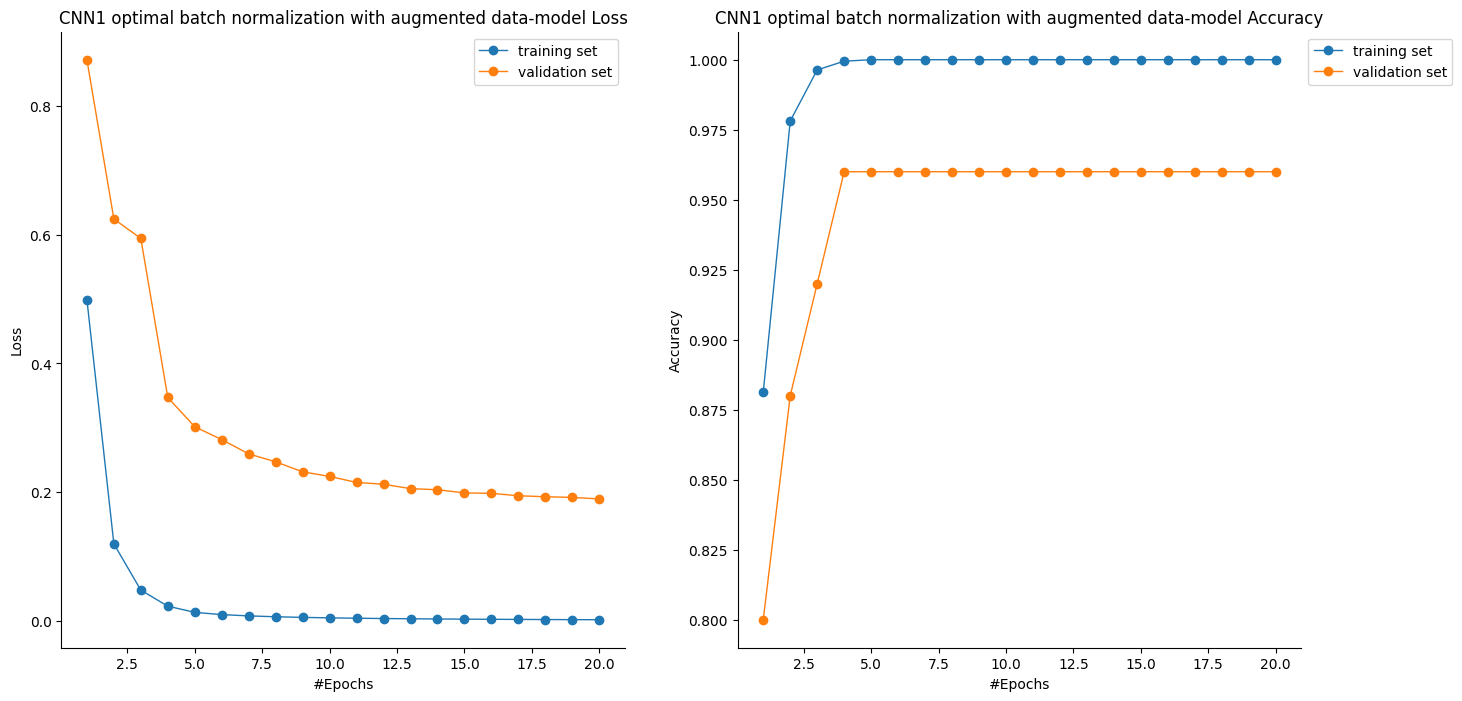

In [ ]:
plot_accuracy_loss('CNN1 optimal batch normalization with augmented data', loss_train, loss_valid, acc_train, acc_valid)

### Evaluate the optimal CNN on the test set

In [ ]:
# Evaluation on test set
test_model(cnn1_optim_trained, testloader) # CNN1 optimal with batch normalization

Test accuracy 0.9113


In [ ]:
# save models
PATH1 = './cnn1norm_aug1_optim_cpu.pth.pth'
torch.save(cnn1_optim_trained.state_dict(), PATH1)